In [1]:
library(rjags)
library(coda)

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


# Do those coins have the same probability of landing heads?

In [34]:
h1 <- 5
h2 <- 8
n1 <- 10
n2 <- 10

data <- list("h1" = h1, "h2" = h2, "n1" = n1, "n2" = n2) # to be passed on to WinBUGS
inits <- list(
  list(theta1 = 0.1, theta2 = 0.9))

parameters <- c("delta", "theta1", "theta2")

In [35]:
model_spec <- "
    model{
       # Observed Counts
       h1 ~ dbin(theta1, n1)
       h2 ~ dbin(theta2, n2)
       # Uniform prior
       theta1 ~ dbeta(1, 1)
       theta2 ~ dbeta(1, 1)
       # Difference between head counts
       delta <- theta1-theta2
    }
"

In [36]:
jags <- jags.model(textConnection(model_spec), inits = inits, data = data, n.adapt=1000)
update(jags, 5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 2
   Total graph size: 11

Initializing model



In [37]:
samples <- coda.samples(jags, parameters, 1000)

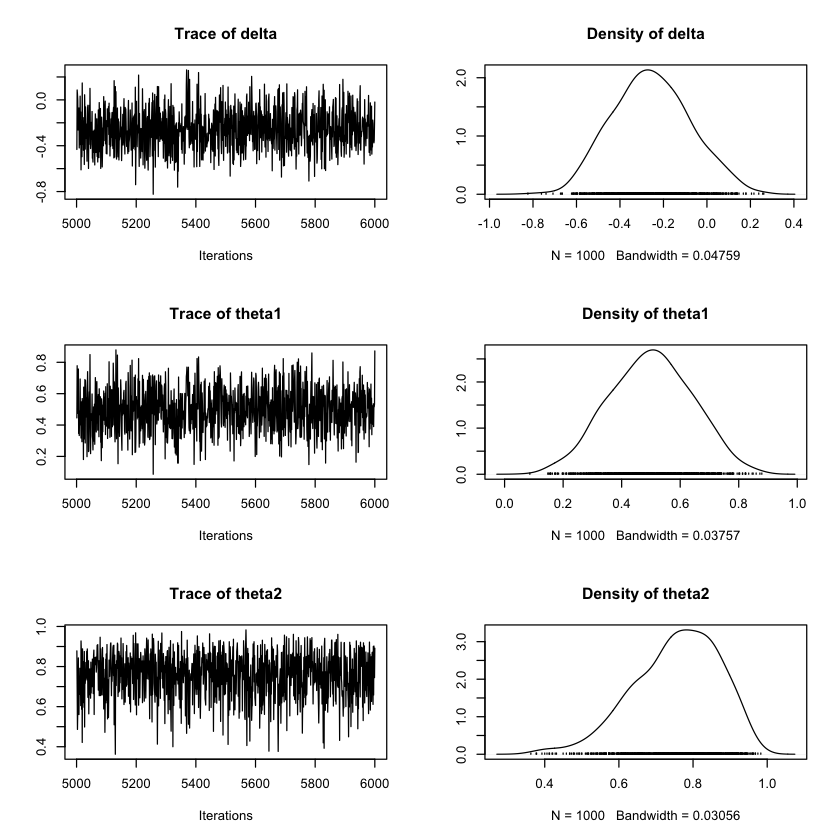

In [38]:
plot(samples[[1]])

In [39]:
HPDinterval(samples, prob = 0.95)

,lower,upper
delta,-0.6069974,0.0749229
theta1,0.1983240,0.7403291
theta2,0.5353836,0.9482822


# Detecting malingering

22 participants completed a memory test. One group was told to do their best (bona fide). The other groups was to under-perform by simulating amnesia. First 10 participants were bona fide and the next 12 were instructed to malinger.

In [40]:
k <- c(45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30)
p <- length(k) # number of people
n <- 45        # number of questions

In [41]:
data <- list("p" = p, "k" = k, "n" = n) # to be passed on to JAGS

In [42]:
model_spec <- "
    model{
      # Each Person Belongs to One of Two Latent Groups
      for (i in 1:p){
        z[i] ~ dbern(0.5)
        z1[i] <- z[i]+1
      }
      # Bona Fide Group has Unknown Success Rate Above Chance
      psi[1] ~ dunif(0.5,1)
      # Malingering Group has Unknown Success Rate Below Bona Fide
      psi[2] ~ dunif(0,psi[1])
      # Data are Binomial with Group Rate for Each Person
      for (i in 1:p){
        theta[i] <- psi[z1[i]]
        k[i] ~ dbin(theta[i],n)
      }
    }
"

In [43]:
inits <- list(
  list(psi = c(0.7,0.5), 
       z = round(runif(p)))
)

In [44]:
jags <- jags.model(textConnection(model_spec), inits = inits, data = data, n.adapt=1000)
update(jags, 5000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 22
   Unobserved stochastic nodes: 24
   Total graph size: 162

Initializing model



In [45]:
samples <- coda.samples(jags, c("psi","z"), 1000)

In [46]:
z_samples <- samples[[1]][,3:(p + 2)]

In [48]:
latents <- colMeans(z_samples)

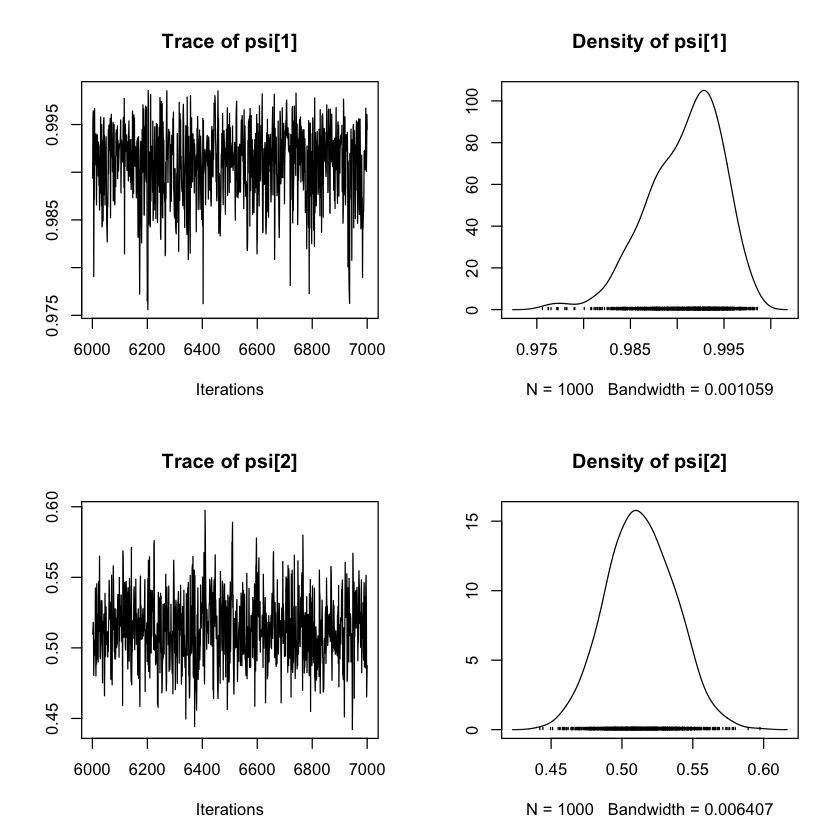

In [49]:
plot(samples[[1]][,1:2])

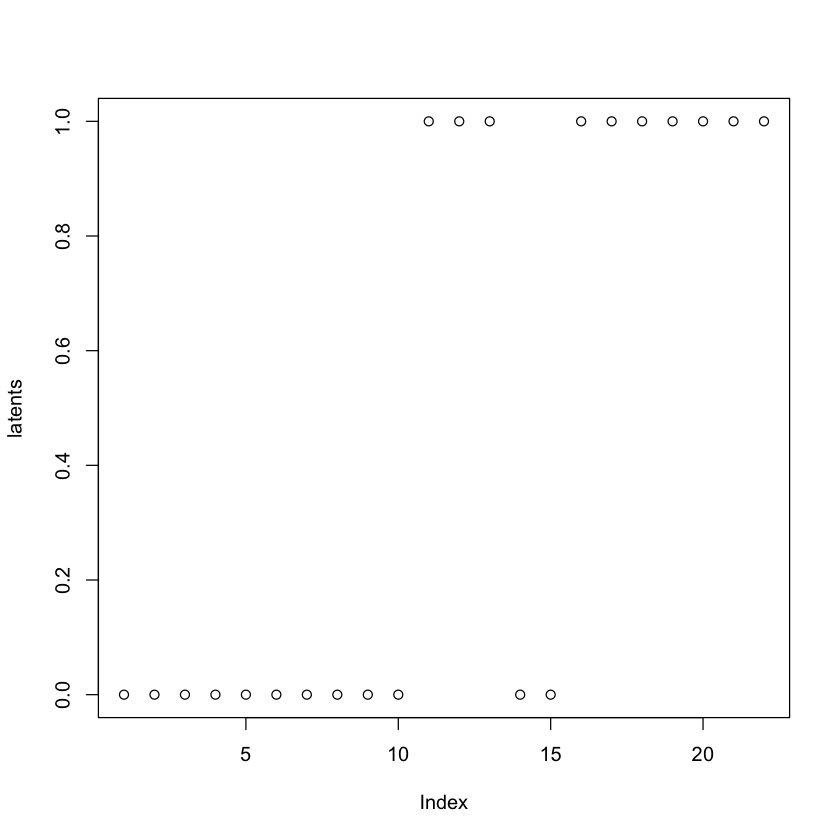

In [50]:
plot(latents)

In [51]:
HPDinterval(samples, prob = 0.95)

,lower,upper
psi[1],0.9834728,0.9978244
psi[2],0.4641312,0.5573214
z[1],0.0000000,0.0000000
z[2],0.0000000,0.0000000
z[3],0.0000000,0.0000000
z[4],0.0000000,0.0000000
z[5],0.0000000,0.0000000
z[6],0.0000000,0.0000000
z[7],0.0000000,0.0000000
z[8],0.0000000,0.0000000


Did all participents followed the instructions? 